In [ ]:
#Src code from video: https://www.youtube.com/watch?v=9mLeVn8xzMw
#Video Playlist: https://www.youtube.com/playlist?list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [36]:
img = cv2.imread('images/self.jpg', 0) # load an image

In [37]:
#Output is a 2D complex array. 1st channel real and 2nd imaginary
#For fft in opencv input image needs to be converted to float32
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

#Rearranges a Fourier transform X by shifting the zero-frequency 
#component to the center of the array.
#Otherwise it starts at the tope left corenr of the image (array)
dft_shift = np.fft.fftshift(dft)

##Magnitude of the function is 20.log(abs(f))
#For values that are 0 we may end up with indeterminate values for log. 
#So we can add 1 to the array to avoid seeing a warning. 
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

In [40]:
# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0


In [39]:
# Circular LPF mask, center circle is 1, remaining all zeros
# Only allows low frequency components - smooth regions
#Can smooth out noise but blurs edges.
#
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r = 100
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 1

In [34]:
# Band Pass Filter - Concentric circle mask, only the points living in concentric circle are ones
rows, cols = img.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.zeros((rows, cols, 2), np.uint8)
r_out = 80
r_in = 10
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                           ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
mask[mask_area] = 1

In [43]:
# apply mask and inverse DFT: Multiply fourier transformed image (values)
#with the mask values. 
fshift = dft_shift * mask

#Get the magnitude spectrum (only for plotting purposes)
fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]) + 1)

#Inverse shift to shift origin back to top left.
f_ishift = np.fft.ifftshift(fshift)

#Inverse DFT to convert back to image domain from the frequency domain. 
#Will be complex numbers
img_back = cv2.idft(f_ishift)

#Magnitude spectrum of the image domain
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

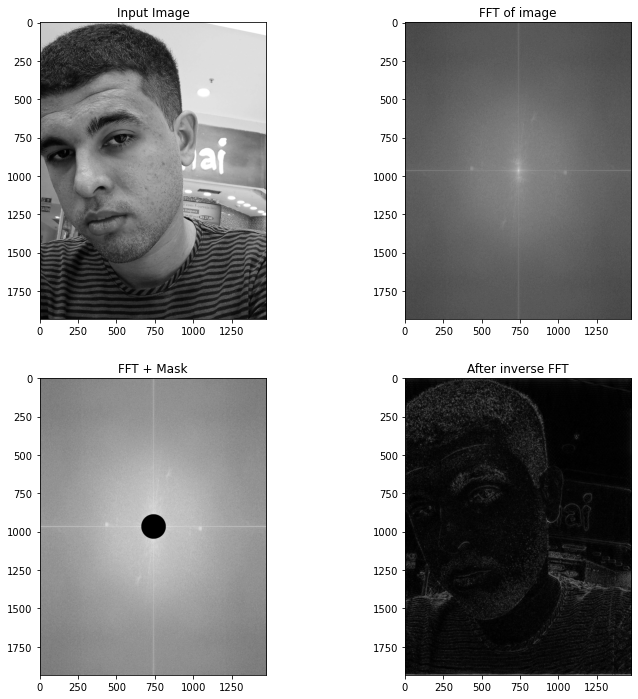

In [44]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text('FFT of image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(fshift_mask_mag, cmap='gray')
ax3.title.set_text('FFT + Mask')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_back, cmap='gray')
ax4.title.set_text('After inverse FFT')
plt.show()